In [803]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


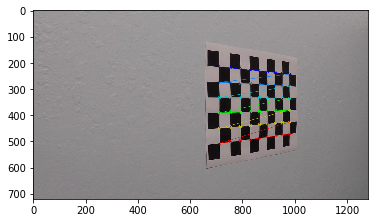

In [804]:
import glob
images = glob.glob('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/camera_cal/calibration*.jpg')

objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane
nx = 6 #enter the number of inside corners in x
ny = 9 #enter the number of inside corners in y


#Prepare object points like (0,0,0),(1,0,0) etc..
objp = np.zeros((6*9,3),np.float32)
#Third column will always be zero. No need to change. Need to populate x and y column. Use mgrid of numpy.
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)#x,y coordinate

#Now we have to create image points. For that we have to detect the corners of the board.

for fname in images:
    #print (fname)
    
    image = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    #If there is any corner point then append it to image point array.
    #Also add prepared obj points to object point array
    #These object points are same for for all of the calibration images as they represent  read chessboard
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        #Display these corner points on an image
        cv2.drawChessboardCorners(image, (9, 6), corners, ret)
        plt.imshow(image)


    

In [805]:
print (len(imgpoints))
print (len(objpoints))

17
17


In [806]:
#Calibration of camera using object points and image points. It retruns camera matrix and distortion coeff in mtx
#and dist variable resp.
#rvecs and tvecs containts position of camera in real world
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [807]:
#Now undistort an image
#dst = cv2.undistort(img, mtx, dist, None, mtx)

In [808]:

#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(img)
#ax1.set_title('Original Image', fontsize=50)
#ax2.imshow(dst)
#ax2.set_title('Undistorted Image', fontsize=50)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

(720, 1280, 3)


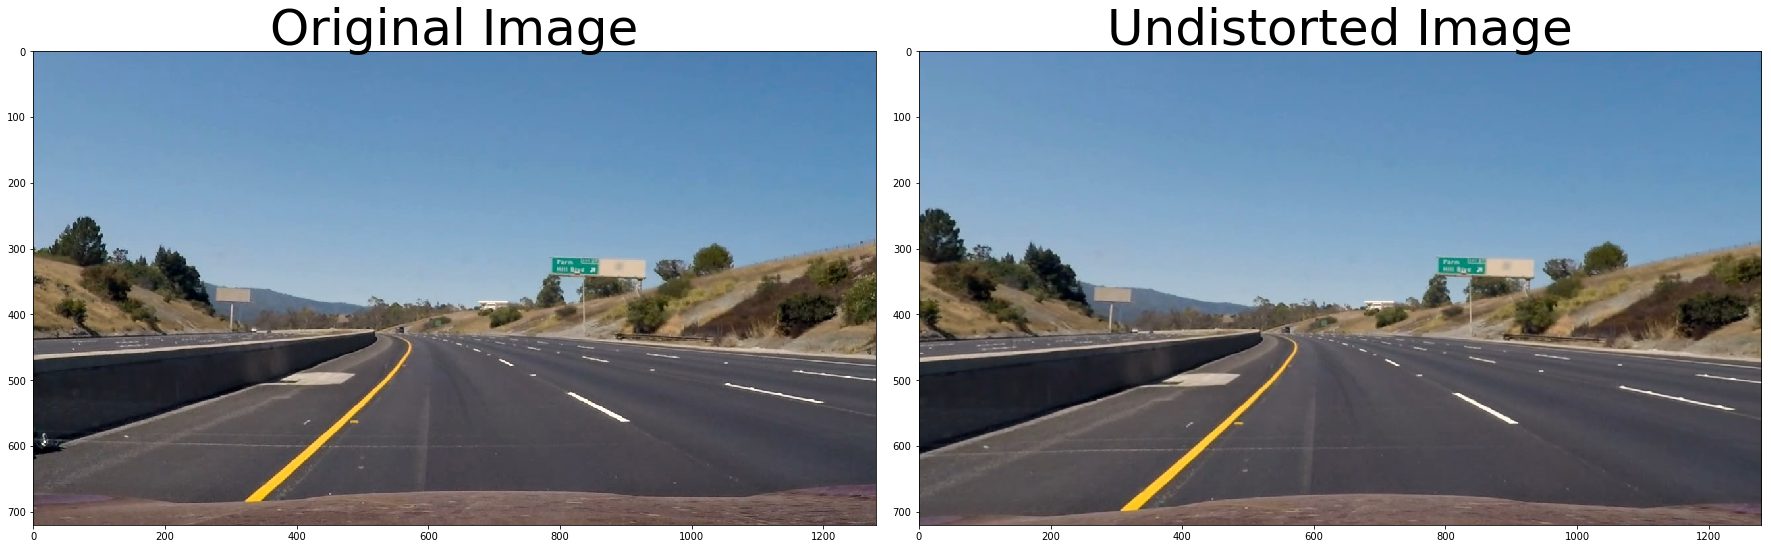

In [809]:
test1 = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/frames/frame10.jpg')
print (test1.shape)
test_dst = cv2.undistort(test1, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [835]:
cv2.imwrite("Original_frame.jpg",cv2.cvtColor(test1,cv2.COLOR_BGR2RGB))
cv2.imwrite("Undistorted_frame.jpg",cv2.cvtColor(test_dst,cv2.COLOR_BGR2RGB))

True

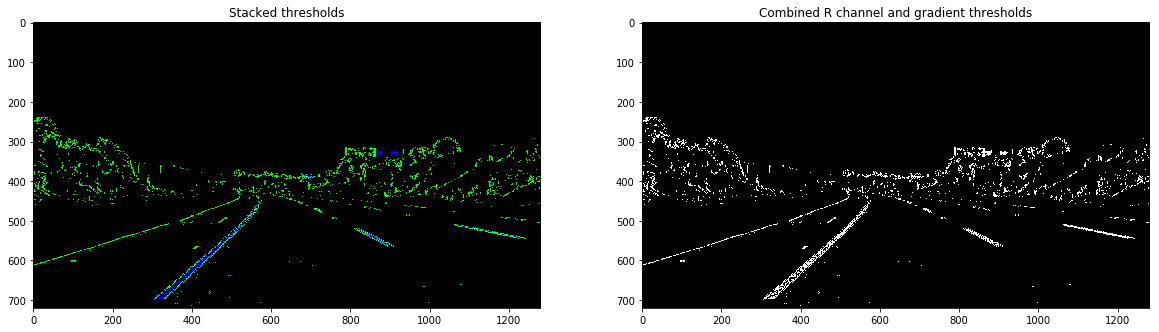

In [833]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(test_dst, cv2.COLOR_RGB2HLS)

h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

hsv1 = cv2.cvtColor(test_dst,cv2.COLOR_RGB2HSV)
h_hsv_channel1 = hsv1[:,:,0]
s_hsv_channel1 = hsv1[:,:,1]
v_hsv_channel1 = hsv1[:,:,2]

r = test_dst[:,:,0]
g = test_dst[:,:,1]
b = test_dst[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray1 = cv2.cvtColor(test_dst, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx1 = cv2.Sobel(gray1, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx1 = np.absolute(sobelx1) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel1 = np.uint8(255*abs_sobelx1/np.max(abs_sobelx1))

# Threshold x gradient
thresh_min1 = 30
thresh_max1 = 100
sxbinary1 = np.zeros_like(scaled_sobel1)
sxbinary1[(scaled_sobel1 >= thresh_min1) & (scaled_sobel1 <= thresh_max1)] = 1

# Threshold color channel
#s_thresh_min1 = 165
#s_thresh_max1 = 254
s_thresh_min1 = 220
s_thresh_max1 = 254
s_binary1 = np.zeros_like(s_channel)
#s_binary1[(s_channel >= s_thresh_min1) & (s_channel <= s_thresh_max1)] = 1
s_binary1[(r >= s_thresh_min1) & (r <= s_thresh_max1)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary1 = np.dstack(( np.zeros_like(sxbinary1), sxbinary1, s_binary1)) * 255

# Combine the two binary thresholds
combined_binary1 = np.zeros_like(sxbinary1)
combined_binary1[(s_binary1 == 1) | (sxbinary1 == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary1)
ax2.set_title('Combined R channel and gradient thresholds')
ax2.imshow(combined_binary1, cmap='gray')



In [834]:
cv2.imwrite("combined.jpg",combined_binary1)

True

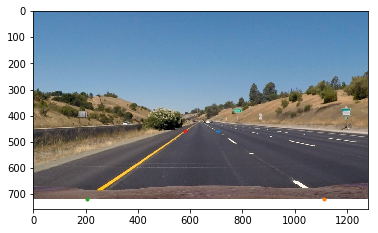

In [813]:
straight_image = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/test_images/straight_lines1.jpg')

plt.imshow(straight_image)
plt.plot(705,460,'.') #Top right
plt.plot(1110,720,'.') #Bottom right
plt.plot(205,720,'.') #Bottom left
plt.plot(580,460,'.') #Top left




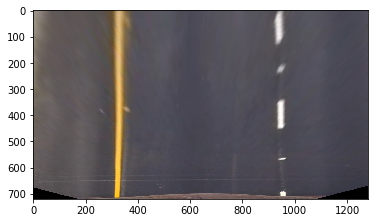

In [814]:
straight_image_dst = cv2.undistort(straight_image, mtx, dist, None, mtx)
src_points = np.float32([[705,460],[1110,720],[205,720],[580,460]])
#src_points = np.float32([[695,460],[1127,720],[203,720],[585,460]])
dst_points = np.float32([[960,0],[960,720],[320,720],[320,0]])
#dst_points = np.float32([[960,0],[960,720],[320,720],[320,0]])

img_size = (straight_image.shape[1],straight_image.shape[0])
M = cv2.getPerspectiveTransform(src_points, dst_points)
Minv = cv2.getPerspectiveTransform(dst_points,src_points)
straight_warped = cv2.warpPerspective(straight_image_dst, M, img_size, flags=cv2.INTER_LINEAR)

plt.imshow(straight_warped)




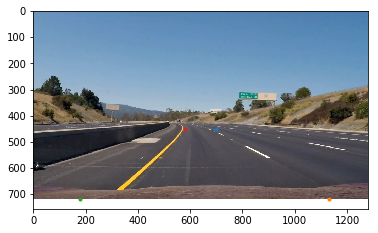

In [815]:
plt.imshow(test1)
plt.plot(700,450,'.') #Top right
plt.plot(1130,720,'.') #Bottom right
plt.plot(180,720,'.') #Bottom left
plt.plot(580,450,'.') #Top left



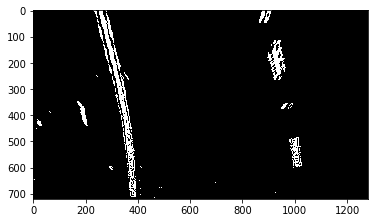

In [816]:
#src_points = np.float32([[700,450],[1130,720],[180,720],[580,450]])
#dst_points = np.float32([[960,0],[960,720],[360,720],[360,0]])

src_points = np.float32([[705,460],[1110,720],[205,720],[580,460]])
#src_points = np.float32([[695,460],[1127,720],[203,720],[585,460]])
dst_points = np.float32([[960,0],[960,720],[320,720],[320,0]])
#dst_points = np.float32([[960,0],[960,720],[320,720],[320,0]])
img_size = (combined_binary1.shape[1],test1.shape[0])
M = cv2.getPerspectiveTransform(src_points, dst_points)
Minv = cv2.getPerspectiveTransform(dst_points,src_points)
warped = cv2.warpPerspective(combined_binary1, M, img_size, flags=cv2.INTER_LINEAR)

plt.imshow(warped,cmap="gray")



In [817]:
cv2.imwrite("warped.jpg",warped)

True

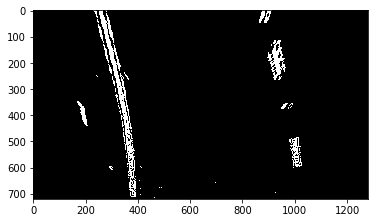

In [818]:
"""
Applies an image mask.

Only keeps the region of the image defined by the polygon
formed from `vertices`. The rest of the image is set to black.
"""
vertices = np.array([[(100,720),(200,0), (1150, 0), (1200,720)]], dtype=np.int32)
#defining a blank mask to start with
mask = np.zeros_like(warped)   

#defining a 3 channel or 1 channel color to fill the mask with depending on the input image
if len(warped.shape) > 2:
    channel_count = warped.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,) * channel_count
else:
    ignore_mask_color = 255

#filling pixels inside the polygon defined by "vertices" with the fill color    
cv2.fillPoly(mask, vertices, ignore_mask_color)

#returning the image only where mask pixels are nonzero
masked_image = cv2.bitwise_and(warped, mask)

plt.imshow(masked_image,cmap='gray')

300


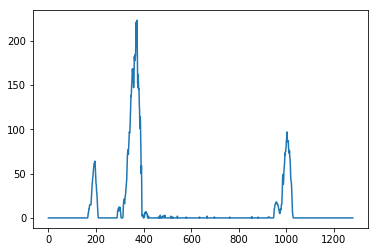

In [819]:
import numpy as np
#histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
print (masked_image.shape[0]//2 - 60)
histogram = np.sum(masked_image[masked_image.shape[0]//2 - 60:,:], axis=0)
plt.plot(histogram)

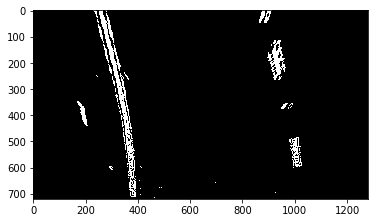

In [820]:
# Create an output image to draw on and  visualize the result
#out_img = np.dstack((warped, warped, warped))*255
out_img = np.dstack((masked_image, masked_image, masked_image))*255
plt.imshow(out_img)



In [821]:
midpoint = np.int(histogram.shape[0]/2)
print (midpoint)

leftx_base = np.argmax(histogram[:midpoint])
print (leftx_base)

rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print (rightx_base)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension



640
372
1002


In [822]:
##Choose the number of sliding windows
#nwindows = 9

##Set height of windows
#window_height = np.int(warped.shape[0]/nwindows)

##Identify x and y positions of all nonzero pixels in the image
#nonzero = warped.nonzero()
#nonzeroy = np.array(nonzero[0])
#nonzerox = np.array(nonzero[1])
## Current positions to be updated for each window
#leftx_current = leftx_base
#rightx_current = rightx_base
## Set the width of the windows +/- margin
#margin = 60
## Set minimum number of pixels found to recenter window
#minpix = 10
## Create empty lists to receive left and right lane pixel indices
#left_lane_inds = []
#right_lane_inds = []



In [823]:
#Choose the number of sliding windows
nwindows = 9

#Set height of windows
window_height = np.int(masked_image.shape[0]/nwindows)

#Identify x and y positions of all nonzero pixels in the image
nonzero = masked_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 78
# Set minimum number of pixels found to recenter window
minpix = 10
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []




In [824]:
win_y_low = masked_image.shape[0] - (0+1)*window_height
win_y_high = masked_image.shape[0] - 0*window_height

print (win_y_low)
print (win_y_high)

640
720


In [825]:
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = masked_image.shape[0] - (window+1)*window_height
    win_y_high = masked_image.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

 # Fit a second order polynomial to each
left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)



(720, 0)

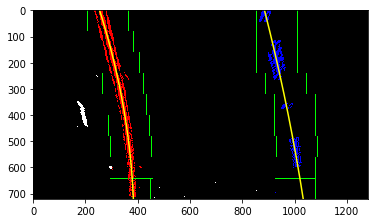

In [826]:
# Generate x and y values for plotting
ploty = np.linspace(0, masked_image.shape[0]-1, masked_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [827]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

2619.27991046 7630.75689904


In [828]:

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

858.112507572 m 2418.54522952 m


(720, 0)

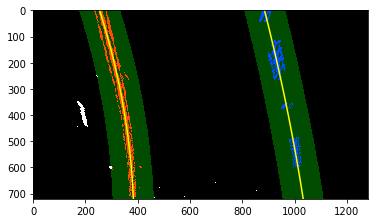

In [829]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((masked_image, masked_image, masked_image))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

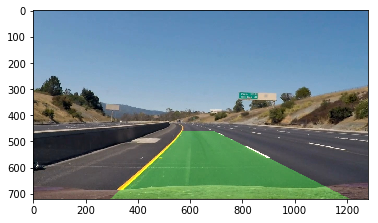

In [830]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(masked_image).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(test1, 1, newwarp, 0.3, 0)
plt.imshow(result)

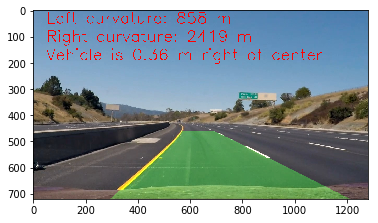

In [836]:
# Calculate vehicle center
fontScale = 2
xMax = result.shape[1]*xm_per_pix
yMax = result.shape[0]*ym_per_pix
vehicleCenter = xMax / 2
lineLeft = left_fit_cr[0]*yMax**2 + left_fit_cr[1]*yMax + left_fit_cr[2]
lineRight = right_fit_cr[0]*yMax**2 + right_fit_cr[1]*yMax + right_fit_cr[2]
lineMiddle = lineLeft + (lineRight - lineLeft)/2
diffFromVehicle = lineMiddle - vehicleCenter
if diffFromVehicle > 0:
    message = '{:.2f} m right'.format(diffFromVehicle)
else:
    message = '{:.2f} m left'.format(-diffFromVehicle)

# Draw info
font = cv2.FONT_HERSHEY_SIMPLEX
fontColor = (255, 0, 0)
cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), font, fontScale, fontColor, 2)
cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 120), font, fontScale, fontColor, 2)
cv2.putText(result, 'Vehicle is {} of center'.format(message), (50, 190), font, fontScale, fontColor, 2)
plt.imshow(result)